<a href="https://colab.research.google.com/github/isra-33/ChineseGP25/blob/main/v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install --upgrade ydata-profiling ipywidgets
# The rest of your code remains the same
from IPython import get_ipython
from IPython.display import display
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import pickle as pk
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from ydata_profiling import ProfileReport
from google.colab import output

In [42]:
moojup = pd.read_csv("/content/sample_data/moojup_transactions.csv",sep=';')

In [43]:
print(" Shape of dataset:", moojup.shape)
print("\n Column names:\n", moojup.columns)

 Shape of dataset: (1000, 56)

 Column names:
 Index(['idTransaction', 'EtatTransaction', 'EtatTransaction2', 'EtatCloture',
       'IdCloture', 'SentTransaction', 'ReceivedTransaction',
       'CancelReceivedTransaction', 'IdMerchant', 'IdMagasin',
       'IdTerminalMerchant', 'IdTerminal', 'IMEI', 'CurrentDate',
       'CurrentTime', 'CurrentDateTimeTPE', 'Transactiontype',
       'TransactionSupport', 'ResponseCode', 'ResponseCodeAnnulation',
       'Amount', 'OriginalAmount', 'TypeAffilieCommission', 'IdHost',
       'BinaryVersion', 'ConfVersion', 'BankOfRequest',
       'ApplicationPrimaryAccountNumber', 'CodeStatus',
       'DateSystemTransaction', 'TimeSystemTransaction', 'AccountType',
       'AcquirerIdentifier', 'AdditionalTerminalCapabilities',
       'AmountAuthorisedNumeric', 'ApplicationExpirationDate',
       'ApplicationInterchangeProfile', 'ApplicationTransactionCounter',
       'CardApplicationVersionNumber', 'TerminalApplicationVersionNumber',
       'PointofService

In [44]:
# Optional: check duplicate rows
duplicate_count = moojup.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

Duplicate rows: 0


<Axes: >

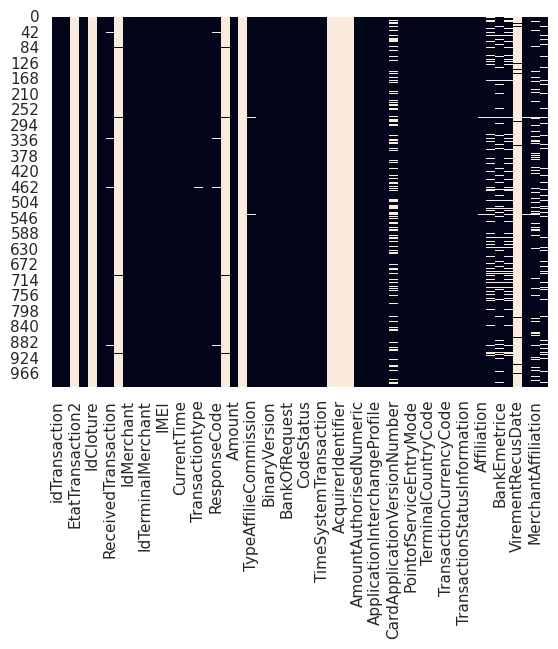

In [45]:
sns.heatmap(moojup.isnull(), cbar=False)

In [46]:
cat_cols = moojup.select_dtypes(include='object').columns
num_cols = moojup.select_dtypes(exclude='object').columns

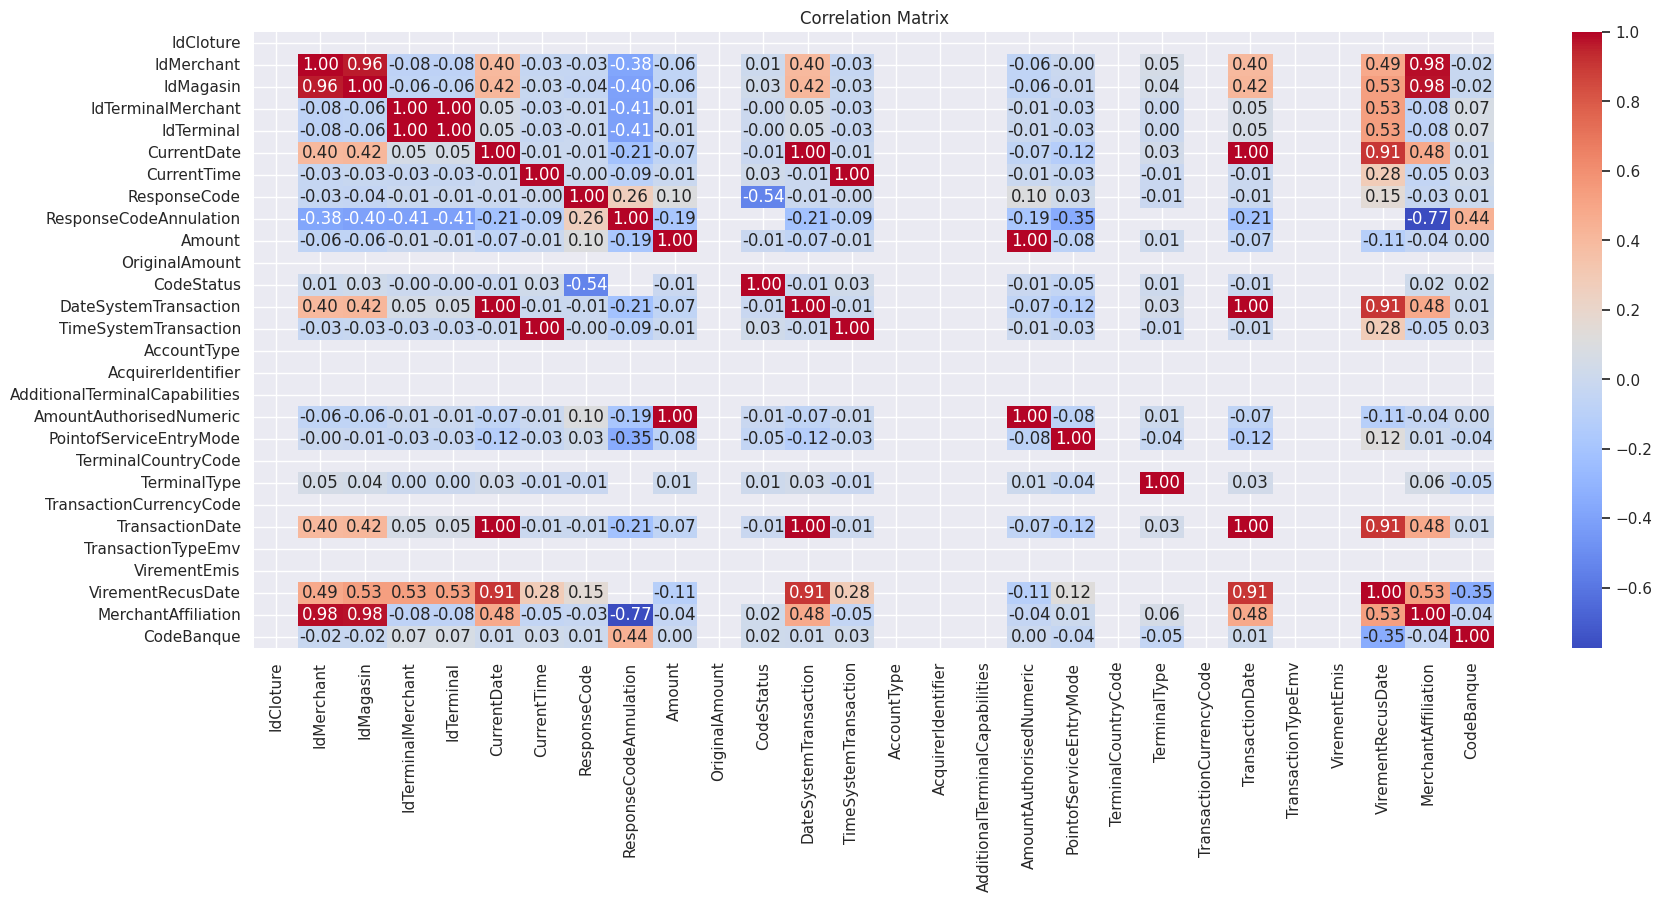

In [47]:
plt.figure(figsize=(20, 8))
sns.heatmap(moojup[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [48]:
moojup[cat_cols].describe().transpose()

,count,unique,top,freq
idTransaction,1000,1000,/FI647EE5kC4GKqA+8AzmQ==,1
EtatTransaction,1000,4,Transaction autorisée,902
EtatTransaction2,1,1,Annulation forcée envoyée et autorisée,1
EtatCloture,1000,1,non_cloturée,1000
SentTransaction,1000,1000,392E303030313832383739303331202020202020313032...,1
ReceivedTransaction,990,990,392E303030313832383739303331202020202020313032...,1
CancelReceivedTransaction,7,7,392E303030313832353539303133202020202020313031...,1
IMEI,1000,126,V9E0039943,88
CurrentDateTimeTPE,1000,1000,V9E003983720250128124653,1
Transactiontype,998,2,Purchase,992


<Axes: >

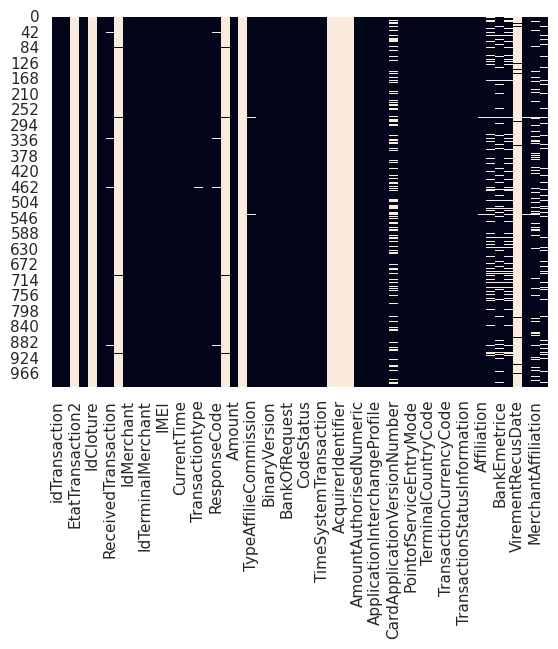

In [49]:
sns.heatmap(moojup.isnull(), cbar=False)

In [50]:
moojup_rename_map = {
    'idTransaction': 'TransactionId',
    'EtatTransaction': 'TransactionState',
    'EtatCloture': 'ClosureState',
    'Transactiontype': 'TransactionType',
    'TransactionSupport': 'TransactionSupport',
    'BankEmetrice': 'IssuingBank',
    'IdMerchant': 'MerchantId',
    'IdMagasin': 'StoreId',
    'IdTerminalMerchant': 'TerminalIdMerchant',
    'IMEI': 'IMEI',
    'BankOfRequest': 'RequestBank',
    'Affiliation': 'Affiliation',
    'VirementEmisDate': 'TransferDateSys',
    'MerchantAffiliation': 'MerchantAffiliation',
    'CurrentDate': 'Date',
    'CurrentTime': 'Time',
    'CodeStatus': 'StatusCode',
    'ResponseCode': 'ResponseCode',
    'ResponseCodeAnnulation': 'CancelResponseCode'
}
moojup = moojup[list(moojup_rename_map.keys())].rename(columns=moojup_rename_map)


null_columns = moojup.columns[moojup.isna().all()]
if len(null_columns) > 0:
  print(f"Dropping columns with 100% null values: {list(null_columns)}")
  moojup.drop(columns=null_columns, inplace=True)
  sns.heatmap(moojup.isnull(), cbar=False)



moojup['ParsedDate'] = pd.to_datetime(moojup['Date'], format='%y%m%d', errors='coerce').dt.date
moojup['ParsedTransferDate'] = pd.to_datetime(moojup['TransferDateSys'], errors='coerce').dt.date
moojup['ParsedTime'] = pd.to_datetime(moojup['Time'], format='%H%M%S', errors='coerce').dt.time
moojup.rename(columns={
            'ParsedDate': 'TransactionDate',
            'ParsedTime': 'TransactionTime',
            'ParsedTransferDate': 'TransferDate'
        }, inplace=True)

moojup.drop(['Date', 'Time', 'TransferDateSys'], axis=1, inplace=True)



columns=['TransferDate','CancelResponseCode','MerchantAffiliation']
moojup.drop(columns=columns, inplace=True)
moojup['ResponseCode'].fillna(-1, inplace=True)
moojup['TransactionType'].fillna('OTHER', inplace=True)
moojup['IssuingBank'].fillna('OTHER', inplace=True)
moojup['Affiliation'].fillna('NO_AFF', inplace=True)



moojup["ResponseCode"] = moojup["ResponseCode"].astype(int)

moojup['TransactionDate'] = pd.to_datetime(moojup['TransactionDate'])

moojup['TransactionTime'] = moojup['TransactionTime'].astype(str).str.zfill(6)

moojup['hour'] = moojup['TransactionTime'].str[0:2].astype(int)

moojup['dayofweek'] = moojup['TransactionDate'].dt.dayofweek
moojup['day'] = moojup['TransactionDate'].dt.day
moojup['month'] = moojup['TransactionDate'].dt.month
moojup['year'] = moojup['TransactionDate'].dt.year
moojup['dayofweek'] = moojup['TransactionDate'].dt.dayofweek
moojup['week'] = moojup['TransactionDate'].dt.isocalendar().week
moojup['is_weekend'] = moojup['dayofweek'].isin([5, 6]).astype(int)

moojup.sort_index(inplace=True)

<ipython-input-50-8b1596ee18dc>:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  moojup['ResponseCode'].fillna(-1, inplace=True)
<ipython-input-50-8b1596ee18dc>:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [51]:
# Approximate dates for Muslim holidays in 2024–2025
holy_holidays = [
    {"holiday": "Start of Ramadan", "year": 2024, "date": "2024-03-10"},
    {"holiday": "Eid al-Fitr", "year": 2024, "date": "2024-04-09"},
    {"holiday": "Eid al-Adha", "year": 2024, "date": "2024-06-17"},
    {"holiday": "Mawlid", "year": 2024, "date": "2024-09-15"},
    {"holiday": "Start of Ramadan", "year": 2025, "date": "2025-02-28"},
    {"holiday": "Eid al-Fitr", "year": 2025, "date": "2025-03-30"},
    {"holiday": "Eid al-Adha", "year": 2025, "date": "2025-06-06"},
    {"holiday": "Mawlid", "year": 2025, "date": "2025-09-03"},
]

# Create DataFrame
df_holidays = pd.DataFrame(holy_holidays)
df_holidays["date"] = pd.to_datetime(df_holidays["date"])
df_holidays["start_window"] = df_holidays["date"] - pd.Timedelta(days=7)
df_holidays["end_window"] = df_holidays["date"] + pd.Timedelta(days=7)

# Keep only useful columns
df_holidays = df_holidays[["holiday", "year", "start_window", "end_window"]]
df_holidays = df_holidays.rename(columns={
    "start_window": "period_start",
    "end_window": "period_end"
})

national_holidays = [
    '01-01',  # New Year’s Day
    '03-20',  # Independence Day
    '04-09',  # Martyrs' Day
    '05-01',  # Labour Day
    '07-25',  # Republic Day
    '08-13',  # Women's Day
    '10-15',  # Evacuation Day
    '12-17',  # Revolution Day
]

def is_national_holiday(date):
    date_str = date.strftime("%m-%d")
    return 1 if date_str in national_holidays else 0

def is_in_holy_period(date, holidays_df):
    for _, row in holidays_df.iterrows():
        if row['period_start'] <= date <= row['period_end']:
            return 1
    return 0

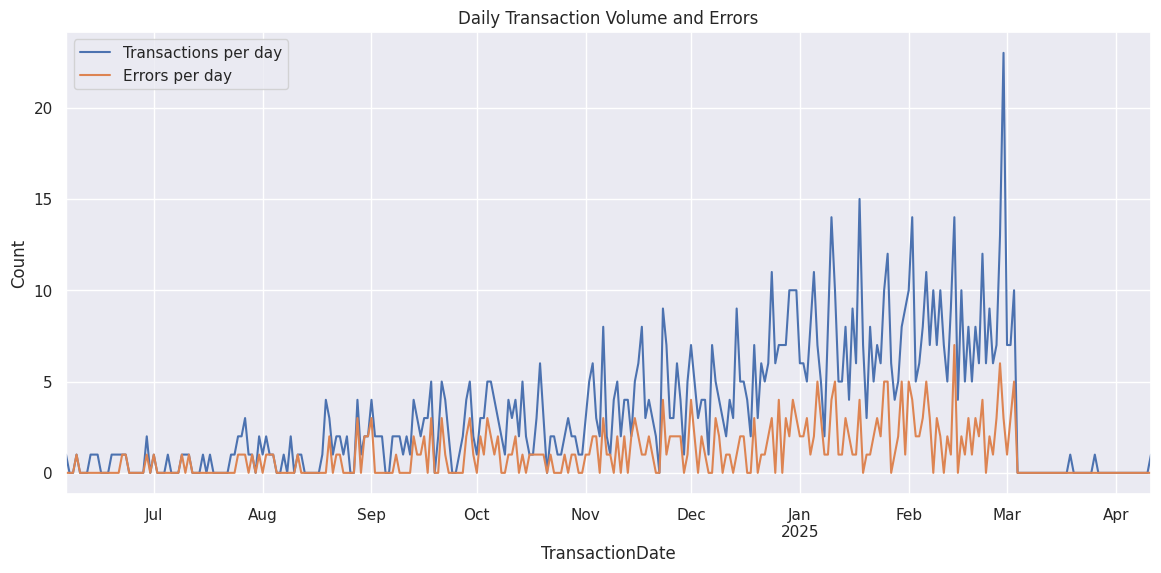

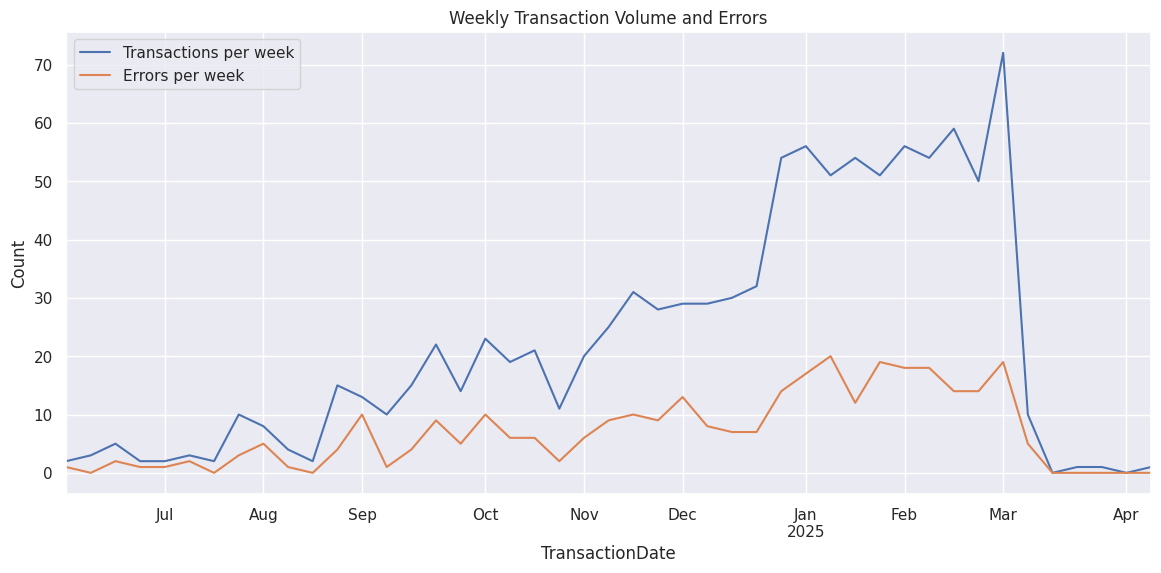

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'TransactionDate' is datetime and set as index
moojup['TransactionDate'] = pd.to_datetime(moojup['TransactionDate'])
moojup.set_index('TransactionDate', inplace=True)

# Convert response code to integer
moojup["ResponseCode"] = moojup["ResponseCode"].astype(int)

# Flag errors: ResponseCode ≠ 0 is an error
moojup["IsError"] = moojup["ResponseCode"] != 0

# ─── DAILY AGGREGATION ─────────────────────────────
transaction_volume_daily = moojup.resample('D').size().rename("TransactionVolume")
errors_daily = moojup["IsError"].resample("D").sum().rename("ErrorCount")

df_errors_daily = pd.concat([transaction_volume_daily, errors_daily], axis=1)
df_errors_daily["ErrorRate"] = df_errors_daily["ErrorCount"] / df_errors_daily["TransactionVolume"]

# Add time-based features
df_errors_daily["weekday"] = df_errors_daily.index.day_name()
df_errors_daily["hour"] = 0  # no hourly detail in daily data

# ─── WEEKLY AGGREGATION ─────────────────────────────
transaction_volume_weekly = moojup.resample('W').size().rename("TransactionVolume")
errors_weekly = moojup["IsError"].resample("W").sum().rename("ErrorCount")

df_errors_weekly = pd.concat([transaction_volume_weekly, errors_weekly], axis=1)
df_errors_weekly["ErrorRate"] = df_errors_weekly["ErrorCount"] / df_errors_weekly["TransactionVolume"]
df_errors_weekly["week_number"] = df_errors_weekly.index.isocalendar().week

# ─── DAILY VISUALIZATION ─────────────────────────────
plt.figure(figsize=(14, 6))
transaction_volume_daily.plot(label="Transactions per day")
errors_daily.plot(label="Errors per day")
plt.legend()
plt.title("Daily Transaction Volume and Errors")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# ─── WEEKLY VISUALIZATION ────────────────────────────
plt.figure(figsize=(14, 6))
transaction_volume_weekly.plot(label="Transactions per week")
errors_weekly.plot(label="Errors per week")
plt.legend()
plt.title("Weekly Transaction Volume and Errors")
plt.ylabel("Count")
plt.grid(True)
plt.show()